# Benchmark case: Logistic Growth.

In this notebook, we benchmark our simulation against a cornerstone analytical model, the logistic growth model. It obeys the differential equation

$ \frac{dN}{dt} = rN(1-\frac{N}{K}) $

$r$ is the growth rate, $K$ is the carrying capacity. 
It has the solution

$ N(t) = \frac{K N_0 \mathrm{e}^{rt}}{K + N_0(\mathrm{e}^{rt}-1)} $ with the initial population $N_0 = N(t=0)$.

We will perform a series of simulations for a single cell line with a zero death rate and zero competition matrix, finite carrying capacity and zero turnover $\theta$. The average growth curve of our simulation should coincide with the analytical solution of the logistic growth model.

## Imports

In [24]:
import multiprocess as mp
import os, shutil, numpy
from matplotlib import pyplot
import math

In [25]:
from GillespieSimulator.GillespieEngine import GillespieEngine
from GillespieSimulator.Parameters import Parameters

## Setup the parameters 

In [26]:
parameters = Parameters(max_time=10,
         max_population_size=None,
         division_rate=1.0,
         division_rate_fwhm=0.0,
         mutation_probability=0.0,
         death_rate=0.0,
         death_rate_fwhm=0.0,
         pdf_mean=0.00,
         pdf_rms=.000,
         barcode_size=0,
         genome_size=1,
         carrying_capacity=1000,
         theta=0,
         )

### Simulation output

In [1]:
output_dir = 'logistic_growth'

In [4]:
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
# os.mkdir(output_dir)

### Define a function that performs a simulation run. 

In [5]:
def run_engine(run_number):
    # print("Setting seed")
    seed = run_number
    numpy.random.seed(seed)
    
    # print("Setting up engine.")
    engine = GillespieEngine(parameters=parameters,
                             population=[1],
                             outdir=os.path.join(output_dir,'gillespie_run_out_{0:04d}'.format(run_number))
                            )
    # print("Running the engine")
    engine.run(snapshot_interval=1)
    
    print("Simulation data was written to {}.".format(engine.outdir))

## Setup the process pool

### Determine number of processes available to this run.

In [6]:
number_of_cpus = mp.cpu_count()
print("There are {} CPUs on this system.".format(number_of_cpus))

There are 48 CPUs on this system.


### Set number of runs 

In [7]:
number_of_runs = 128
runs = range(number_of_runs)

### Set the number of cpus to use in this run.
This number should be equal or less to the number of simulations to run to avoid idling processes. It's ok to oversubscribe the CPU that is to make a pool that has more processes than there are CPU cores.

In [8]:
pool_size = 42

In [9]:
with mp.Pool(pool_size) as pool:

### We use the `imap_unordered` method of `Pool` to take advantage of the `chunksize` parameter, which in the case of many long runs reduces the memory consumption. 
    pool.imap_unordered(run_engine, runs, chunksize=1)
    pool.close()
    pool.join()

Simulation data was written to logistic_growth/gillespie_run_out_0001.
Simulation data was written to logistic_growth/gillespie_run_out_0034.
Simulation data was written to logistic_growth/gillespie_run_out_0015.
Simulation data was written to logistic_growth/gillespie_run_out_0029.
Simulation data was written to logistic_growth/gillespie_run_out_0012.
Simulation data was written to logistic_growth/gillespie_run_out_0038.
Simulation data was written to logistic_growth/gillespie_run_out_0006.
Simulation data was written to logistic_growth/gillespie_run_out_0041.
Simulation data was written to logistic_growth/gillespie_run_out_0017.
Simulation data was written to logistic_growth/gillespie_run_out_0008.
Simulation data was written to logistic_growth/gillespie_run_out_0011.
Simulation data was written to logistic_growth/gillespie_run_out_0035.
Simulation data was written to logistic_growth/gillespie_run_out_0024.
Simulation data was written to logistic_growth/gillespie_run_out_0037.Simulat

## Visualize results

In [2]:
from GillespieSimulator.analysis import *

In [3]:
runs = load_runs([os.path.join(output_dir,d) for d in os.listdir(output_dir)])

## Take average over all runs

### Setup a dataframe for all cell frequencies over time

In [4]:
all_runs = dict([(run, mutants(runs[run]).groupby(axis=1, level='Barcode ID').sum().values[:,0]) for run in runs.keys()])

Some runs have only 9 or 10 snapshots (11 expected). Filter them out.

In [5]:
all_runs = dict([(k,v) for k,v in all_runs.items() if len(v) == 11])

In [6]:
# Convert to a dataframe

all_runs = pandas.DataFrame(all_runs)

In [7]:
all_runs.index.name = "time (generations)"
all_runs.columns.name = "run #"

In [31]:
all_runs

run #                 1      5      7      8      9      13     15     16   \
time (generations)                                                           
0                     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1                     7.0    2.0    6.0    7.0    3.0    2.0    2.0    2.0   
2                    18.0    5.0   19.0   22.0    8.0    5.0    7.0    6.0   
3                    42.0   20.0   70.0   64.0   23.0   14.0   31.0   23.0   
4                   117.0   58.0  164.0  149.0   87.0   33.0   58.0   60.0   
5                   249.0  127.0  364.0  326.0  203.0   72.0  163.0  145.0   
6                   488.0  289.0  600.0  561.0  397.0  169.0  328.0  322.0   
7                   734.0  531.0  808.0  778.0  637.0  351.0  557.0  589.0   
8                   897.0  762.0  923.0  908.0  824.0  609.0  779.0  809.0   
9                   968.0  892.0  966.0  969.0  922.0  799.0  916.0  920.0   
10                  982.0  955.0  986.0  978.0  959.0  894.0  949.0  959.0   

run #                 17     20   ...    118    119    120    121    122  \
time (generations)                ...                                      
0                     1.0    1.0  ...    1.0    1.0    1.0    1.0    1.0   
1                     2.0    2.0  ...    3.0    2.0    7.0    8.0    5.0   
2                     4.0    5.0  ...    8.0    7.0   20.0   21.0   13.0   
3                    12.0   14.0  ...   17.0   23.0   48.0   52.0   45.0   
4                    30.0   55.0  ...   46.0   70.0  117.0  139.0  132.0   
5                    77.0  153.0  ...  103.0  188.0  284.0  305.0  284.0   
6                   174.0  320.0  ...  214.0  383.0  555.0  554.0  539.0   
7                   369.0  570.0  ...  439.0  630.0  764.0  773.0  768.0   
8                   605.0  802.0  ...  672.0  809.0  911.0  900.0  886.0   
9                   805.0  921.0  ...  840.0  925.0  965.0  962.0  954.0   
10                  904.0  934.0  ...  907.0  962.0  986.0  980.0  982.0   

run #                 123    124    125    126    127  
time (generations)                                     
0                     1.0    1.0    1.0    1.0    1.0  
1                     4.0    5.0    3.0    3.0    3.0  
2                     9.0   13.0    9.0    7.0   11.0  
3                    24.0   27.0   23.0   20.0   37.0  
4                    76.0   88.0   57.0   70.0   77.0  
5                   181.0  218.0  146.0  169.0  192.0  
6                   371.0  418.0  308.0  350.0  382.0  
7                   607.0  661.0  547.0  589.0  637.0  
8                   818.0  844.0  770.0  799.0  824.0  
9                   929.0  945.0  901.0  914.0  932.0  
10                  962.0  974.0  953.0  946.0  954.0  

[11 rows x 93 columns]

### Compare simulation results to model 

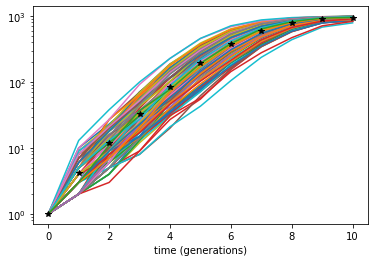

In [30]:
# Plot all runs
fig, ax = pyplot.subplots(1,1)
all_runs.plot(logy=True, legend=False, ax=ax)
all_runs.mean(axis=1).plot(logy=True, ax=ax, style="*k")

#### The logistic growth model.

In [27]:
def logistic_growth_model(t):
    K = parameters.carrying_capacity
    N0 = 1
    r = parameters.division_rate * math.log(2)
    r = parameters.division_rate 
    
    model = (K * N0 * numpy.exp(r*t))/(K + N0 * (numpy.exp(r*t) - 1.0))
    
    return model

#### Get descriptive statistics of the time series.

In [32]:
stats = all_runs.T.describe().T

In [33]:
stats

count        mean         std    min    25%    50%    75%  \
time (generations)                                                              
0                    93.0    1.000000    0.000000    1.0    1.0    1.0    1.0   
1                    93.0    4.150538    2.386312    2.0    2.0    3.0    5.0   
2                    93.0   11.752688    6.660487    3.0    7.0    9.0   16.0   
3                    93.0   32.344086   18.858451    8.0   18.0   27.0   43.0   
4                    93.0   84.430108   47.038004   20.0   51.0   70.0  114.0   
5                    93.0  194.602151   95.296008   43.0  128.0  170.0  249.0   
6                    93.0  379.236559  141.216100  105.0  286.0  371.0  472.0   
7                    93.0  603.881720  145.620848  237.0  508.0  607.0  715.0   
8                    93.0  794.043011  106.536676  438.0  743.0  804.0  877.0   
9                    93.0  909.064516   58.440569  680.0  892.0  921.0  954.0   
10                   93.0  943.473118   42.718897  789.0  927.0  955.0  975.0   

                      max  
time (generations)         
0                     1.0  
1                    13.0  
2                    38.0  
3                   100.0  
4                   228.0  
5                   459.0  
6                   712.0  
7                   874.0  
8                   948.0  
9                   978.0  
10                  994.0

#### Plot model and data on the same graph. 
We generate a boxplot showing the mean, 25%, 50%, and 75% quartiles, 1.5 fold whiskers and plot the model as a smooth curve.

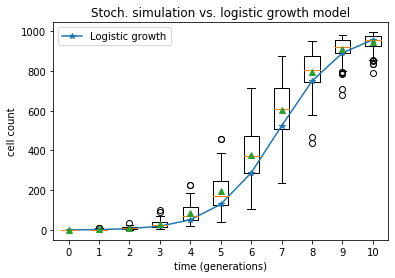

In [44]:
fig, ax = pyplot.subplots()
times = all_runs.index.values
bp = ax.boxplot(all_runs, showmeans=True, labels=all_runs.index, positions=all_runs.index)
#ax.semilogy(times, logistic_growth_model(times), label="Logistic growth")
ax.plot(times, logistic_growth_model(times), '*-', label="Logistic growth")
ax.set_xlabel('time (generations)')
ax.set_ylabel('cell count')
ax.set_title("Stoch. simulation vs. logistic growth model")
ax.legend()

## Conclusion
The logistic growth model pretty much reproduces the simulation data. We may therefore assume that the
carrying capacity is correctly implemented.